# SpaCy NLP Tools Implementation

This notebook demonstrates the implementation of 8 essential NLP processing tools using SpaCy:

1. **Sentence Splitter** - Splits text into individual sentences
2. **Tokenization** - Breaks text into individual tokens (words, punctuation)
3. **Stemming** - Reduces words to their root form
4. **Lemmatization** - Reduces words to their canonical/dictionary form
5. **Entity Masking** - Identifies and masks named entities
6. **POS Tagger** - Identifies parts of speech for each token
7. **Phrase Chunking** - Groups tokens into meaningful phrases
8. **Syntactic Parser** - Analyzes grammatical structure and dependencies

In [1]:
# Import required libraries
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from typing import List, Dict
from spacy.language import Language


# Load the English language model
nlp = spacy.load('en_core_web_sm')

print(f"SpaCy version: {spacy.__version__}")
print(f"Model loaded: {nlp.meta['name']} v{nlp.meta['version']}")

SpaCy version: 3.8.7
Model loaded: core_web_sm v3.8.0


## Sample Research Paper Abstract

In [2]:
# Research paper abstract - "Attention Is All You Need In Speech Separation" by Subakan et al.
abstract = """
Recurrent Neural Networks (RNNs) have long been the dominant architecture in sequence-to-sequence learning.
RNNs, however, are inherently sequential models that do not allow parallelization of their computations.
Transformers are emerging as a natural alternative to standard RNNs, replacing recurrent computations 
with a multi-head attention mechanism. In this paper, we propose the SepFormer, a novel RNN-free
Transformer-based neural network for speech separation. The Sep-Former learns short and long-term
dependencies with a multi-scale approach that employs transformers. The proposed model achieves
state-of-the-art (SOTA) performance on the standard WSJ0-2/3mix datasets. It reaches an SI-SNRi
of 22.3 dB on WSJ0-2mix and an SI-SNRi of 19.5 dB on WSJ0-3mix. The SepFormer inherits the parallelization
advantages of Transformers and achieves a competitive performance even when downsampling the encoded
representation by a factor of 8. It is thus significantly faster and it is less memory-demanding
than the latest speech separation systems with comparable performance.
""".strip()

print("Research Paper Abstract:")
print("=" * 50)
print(abstract)
print("\nText length:", len(abstract), "characters")

Research Paper Abstract:
Recurrent Neural Networks (RNNs) have long been the dominant architecture in sequence-to-sequence learning.
RNNs, however, are inherently sequential models that do not allow parallelization of their computations.
Transformers are emerging as a natural alternative to standard RNNs, replacing recurrent computations 
with a multi-head attention mechanism. In this paper, we propose the SepFormer, a novel RNN-free
Transformer-based neural network for speech separation. The Sep-Former learns short and long-term
dependencies with a multi-scale approach that employs transformers. The proposed model achieves
state-of-the-art (SOTA) performance on the standard WSJ0-2/3mix datasets. It reaches an SI-SNRi
of 22.3 dB on WSJ0-2mix and an SI-SNRi of 19.5 dB on WSJ0-3mix. The SepFormer inherits the parallelization
advantages of Transformers and achieves a competitive performance even when downsampling the encoded
representation by a factor of 8. It is thus significantly faster

# 1. Sentence Splitter

In [3]:
def sentence_splitter(text: str, nlp_model: Language) -> List[str]:
    doc = nlp_model(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

sentences = sentence_splitter(abstract, nlp)

print("Sentence Splitter Results:")
print("=" * 30)
print(f"Number of sentences: {len(sentences)}\n")

for i, sentence in enumerate(sentences, 1):
    print(f"Sentence {i}: {sentence}\n")

Sentence Splitter Results:
Number of sentences: 9

Sentence 1: Recurrent Neural Networks (RNNs) have long been the dominant architecture in sequence-to-sequence learning.

Sentence 2: RNNs, however, are inherently sequential models that do not allow parallelization of their computations.

Sentence 3: Transformers are emerging as a natural alternative to standard RNNs, replacing recurrent computations 
with a multi-head attention mechanism.

Sentence 4: In this paper, we propose the SepFormer, a novel RNN-free
Transformer-based neural network for speech separation.

Sentence 5: The Sep-Former learns short and long-term
dependencies with a multi-scale approach that employs transformers.

Sentence 6: The proposed model achieves
state-of-the-art (SOTA) performance on the standard WSJ0-2/3mix datasets.

Sentence 7: It reaches an SI-SNRi
of 22.3 dB on WSJ0-2mix and an SI-SNRi of 19.5 dB on WSJ0-3mix.

Sentence 8: The SepFormer inherits the parallelization
advantages of Transformers and achie

# 2. Tokenization

In [4]:
def tokenization(text: str, nlp_model: Language):
    doc = nlp_model(text)
    tokens = []
    
    for token in doc:
        tokens.append({
            'text': token.text,
            'is_alpha': token.is_alpha,
            'is_punct': token.is_punct,
            'is_space': token.is_space,
            'is_stop': token.is_stop,
            'shape': token.shape_
        })
    
    return tokens, doc

tokens, doc = tokenization(abstract, nlp)

print("Tokenization Results:")
print("=" * 25)
print(f"Total tokens: {len(tokens)}\n")

token_df = pd.DataFrame(tokens[:40])
print("First 40 tokens:")
print(token_df.to_string(index=False))

alpha_tokens = sum(1 for t in tokens if t['is_alpha'])
punct_tokens = sum(1 for t in tokens if t['is_punct'])
stop_tokens = sum(1 for t in tokens if t['is_stop'])

print(f"\nToken Statistics:")
print(f"Alphabetic tokens: {alpha_tokens}")
print(f"Punctuation tokens: {punct_tokens}")
print(f"Stop words: {stop_tokens}")

Tokenization Results:
Total tokens: 209

First 40 tokens:
           text  is_alpha  is_punct  is_space  is_stop shape
      Recurrent      True     False     False    False Xxxxx
         Neural      True     False     False    False Xxxxx
       Networks      True     False     False    False Xxxxx
              (     False      True     False    False     (
           RNNs      True     False     False    False  XXXx
              )     False      True     False    False     )
           have      True     False     False     True  xxxx
           long      True     False     False    False  xxxx
           been      True     False     False     True  xxxx
            the      True     False     False     True   xxx
       dominant      True     False     False    False  xxxx
   architecture      True     False     False    False  xxxx
             in      True     False     False     True    xx
       sequence      True     False     False    False  xxxx
              -     False  

# 3. Stemming

In [5]:
def simple_stemmer(word: str) -> str:
    word = word.lower()

    # Ordered suffixes (longer first to avoid conflicts)
    suffixes = [
        ("ational", "ate"),
        ("tional", "tion"),
        ("iveness", "ive"),
        ("fulness", "ful"),
        ("ousness", "ous"),
        ("biliti", "ble"),
        ("lessli", "less"),
        ("entli", "ent"),
        ("ation", "ate"),
        ("izer", "ize"),
        ("ing", ""),
        ("edly", ""),
        ("edly", "e"),
        ("edly", ""),
        ("ed", ""),
        ("ies", "y"),
        ("ied", "y"),
        ("s", ""),
        ("es", ""),
        ("er", ""),
        ("est", ""),
        ("ness", ""),
        ("ment", ""),
    ]

    for suffix, replacement in suffixes:
        if word.endswith(suffix) and len(word) > len(suffix) + 2:
            stem = word[:-len(suffix)] + replacement

            # Fix double consonants after removing "ing" or "ed"
            if suffix in ("ing", "ed") and len(stem) > 2 and stem[-1] == stem[-2]:
                stem = stem[:-1]

            return stem

    return word


def stemming(text: str, nlp_model: Language) -> List[Dict[str, str]]:
    doc = nlp_model(text)
    stemmed_tokens = []
    
    for token in doc:
        if token.is_alpha and not token.is_stop:
            stemmed = simple_stemmer(token.text)
            stemmed_tokens.append({
                "original": token.text,
                "stemmed": stemmed,
                "pos": token.pos_
            })
    
    return stemmed_tokens

stemmed_tokens = stemming(abstract, nlp)

print("Stemming Results:")
print("=" * 20)
print(f"Total stemmed tokens: {len(stemmed_tokens)}\n")

different_stems = [t for t in stemmed_tokens if t['original'].lower() != t['stemmed']]

print("Examples where stemming changed the word:")
stem_df = pd.DataFrame(different_stems[:15])
if not stem_df.empty:
    print(stem_df.to_string(index=False))
else:
    print("No significant stemming changes found with simple rules.")

Stemming Results:
Total stemmed tokens: 91

Examples where stemming changed the word:
       original       stemmed   pos
       Networks       network PROPN
           RNNs           rnn PROPN
       learning         learn  NOUN
           RNNs           rnn  NOUN
         models         model  NOUN
parallelization parallelizate  NOUN
   computations   computation  NOUN
   Transformers   transformer  NOUN
       emerging         emerg  VERB
           RNNs           rnn  NOUN
      replacing        replac  VERB
   computations   computation  NOUN
          paper           pap  NOUN
      SepFormer       sepform PROPN
    Transformer     transform PROPN


# 4. Lemmatization

In [6]:
def lemmatization(text, nlp_model):
    doc = nlp_model(text)
    lemmatized_tokens = []
    
    for token in doc:
        if token.is_alpha:
            lemmatized_tokens.append({
                'original': token.text,
                'lemma': token.lemma_,
                'pos': token.pos_,
                'is_stop': token.is_stop
            })
    
    return lemmatized_tokens

lemmatized_tokens = lemmatization(abstract, nlp)

print("Lemmatization Results:")
print("=" * 25)
print(f"Total lemmatized tokens: {len(lemmatized_tokens)}\n")

different_lemmas = [t for t in lemmatized_tokens if t['original'].lower() != t['lemma'].lower()]

print("Examples where lemmatization changed the word:")
lemma_df = pd.DataFrame(different_lemmas[:20])
print(lemma_df.to_string(index=False))

non_stop_lemmas = [t['lemma'].lower() for t in lemmatized_tokens if not t['is_stop']]
common_lemmas = Counter(non_stop_lemmas).most_common(10)

print(f"\nMost common lemmas (excluding stop words):")
for lemma, count in common_lemmas:
    print(f"{lemma}: {count}")

Lemmatization Results:
Total lemmatized tokens: 155

Examples where lemmatization changed the word:
    original       lemma  pos  is_stop
        been          be  AUX     True
        RNNs         rnn NOUN    False
         are          be  AUX     True
      models       model NOUN    False
computations computation NOUN    False
Transformers transformer NOUN    False
         are          be  AUX     True
    emerging      emerge VERB    False
        RNNs         rnn NOUN    False
   replacing     replace VERB    False
computations computation NOUN    False
       based        base VERB    False
      learns       learn VERB    False
dependencies  dependency NOUN    False
     employs      employ VERB    False
transformers transformer NOUN    False
    proposed     propose VERB    False
    achieves     achieve VERB    False
    datasets     dataset NOUN    False
     reaches       reach VERB    False

Most common lemmas (excluding stop words):
rnn: 3
transformer: 3
performance: 3


# 5. Entity Masking

In [7]:
def entity_masking(text, nlp_model, mask_char="[MASK]"):
    doc = nlp_model(text)
    entities = []
    
    for ent in doc.ents:
        entities.append({
            'text': ent.text,
            'label': ent.label_,
            'description': spacy.explain(ent.label_),
            'start': ent.start_char,
            'end': ent.end_char
        })
    
    masked_text = text
    for ent in sorted(doc.ents, key=lambda x: x.start_char, reverse=True):
        mask_replacement = f"{mask_char}_{ent.label_}"
        masked_text = masked_text[:ent.start_char] + mask_replacement + masked_text[ent.end_char:]
    
    return entities, masked_text

entities, masked_text = entity_masking(abstract, nlp)

print("Entity Masking Results:")
print("=" * 25)
print(f"Found {len(entities)} named entities\n")

if entities:
    entities_df = pd.DataFrame(entities)
    print("Named Entities Found:")
    print(entities_df[['text', 'label', 'description']].to_string(index=False))
    
    entity_counts = Counter([ent['label'] for   ent in entities])
    print(f"\nEntity Label Distribution:")
    for label, count in entity_counts.items():
        print(f"{label}: {count}")
else:
    print("No named entities found.")

print(f"\nMasked Text:")
print("-" * 40)
print(masked_text)
print("\n\nOriginal Text:")
print("-" * 40)
print(abstract)

Entity Masking Results:
Found 9 named entities

Named Entities Found:
                     text    label                                          description
Recurrent Neural Networks      ORG              Companies, agencies, institutions, etc.
                SepFormer      ORG              Companies, agencies, institutions, etc.
              WSJ0-2/3mix    EVENT Named hurricanes, battles, wars, sports events, etc.
                     22.3 CARDINAL         Numerals that do not fall under another type
                WSJ0-2mix     DATE                Absolute or relative dates or periods
                     19.5 CARDINAL         Numerals that do not fall under another type
                WSJ0-3mix     DATE                Absolute or relative dates or periods
                SepFormer      ORG              Companies, agencies, institutions, etc.
                        8 CARDINAL         Numerals that do not fall under another type

Entity Label Distribution:
ORG: 3
EVENT: 1
CARDIN

# 6. POS Tagger

POS Tagging Results:
Total tokens: 199

First 15 tokens with POS tags:
        text   pos pos_description
   Recurrent PROPN     proper noun
      Neural PROPN     proper noun
    Networks PROPN     proper noun
           ( PUNCT     punctuation
        RNNs PROPN     proper noun
           ) PUNCT     punctuation
        have   AUX       auxiliary
        long   ADV          adverb
        been   AUX       auxiliary
         the   DET      determiner
    dominant   ADJ       adjective
architecture  NOUN            noun
          in   ADP      adposition
    sequence  NOUN            noun
           - PUNCT     punctuation

POS Tag Distribution:
NOUN (noun): 39
PUNCT (punctuation): 33
PROPN (proper noun): 22
ADJ (adjective): 22
ADP (adposition): 20
DET (determiner): 19
VERB (verb): 14
AUX (auxiliary): 7
ADV (adverb): 7
PRON (pronoun): 7
CCONJ (coordinating conjunction): 4
NUM (numeral): 3
PART (particle): 1
SCONJ (subordinating conjunction): 1


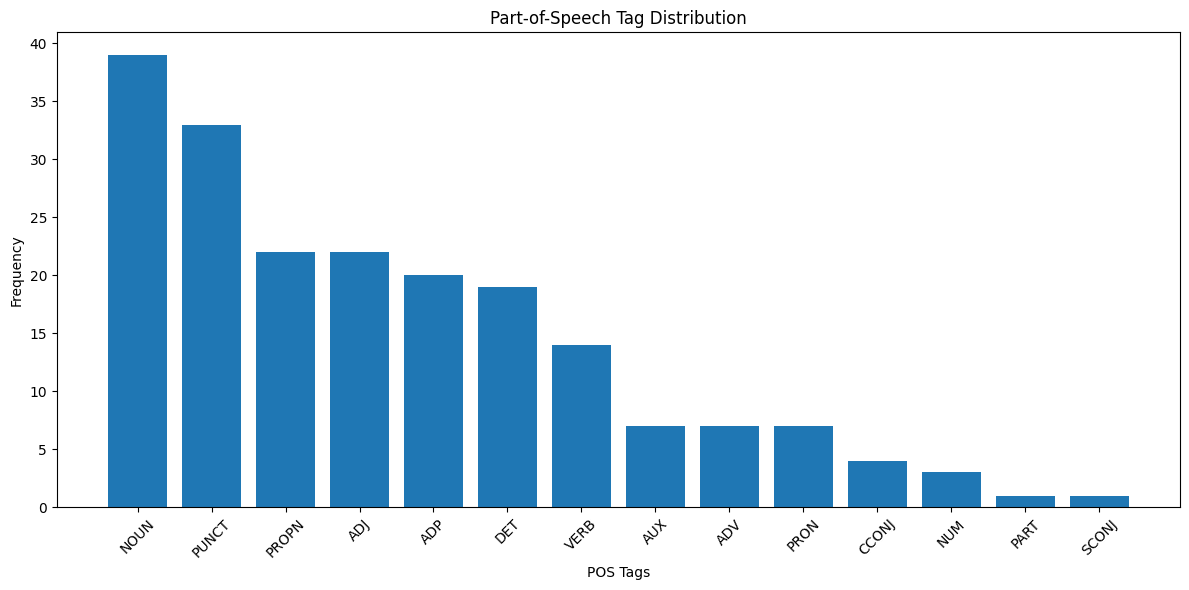

In [8]:
def pos_tagging(text, nlp_model):
    doc = nlp_model(text)
    pos_tokens = []
    
    for token in doc:
        if not token.is_space:
            pos_tokens.append({
                'text': token.text,
                'pos': token.pos_,
                'tag': token.tag_,
                'pos_description': spacy.explain(token.pos_),
                'tag_description': spacy.explain(token.tag_)
            })
    
    return pos_tokens

pos_tokens = pos_tagging(abstract, nlp)

print("POS Tagging Results:")
print("=" * 22)
print(f"Total tokens: {len(pos_tokens)}\n")

pos_df = pd.DataFrame(pos_tokens[:15])
print("First 15 tokens with POS tags:")
print(pos_df[['text', 'pos', 'pos_description']].to_string(index=False))

pos_counts = Counter([token['pos'] for token in pos_tokens])
print(f"\nPOS Tag Distribution:")
for pos, count in pos_counts.most_common():
    description = spacy.explain(pos) or pos
    print(f"{pos} ({description}): {count}")

plt.figure(figsize=(12, 6))
pos_labels, pos_counts_values = zip(*pos_counts.most_common())
plt.bar(pos_labels, pos_counts_values)
plt.title('Part-of-Speech Tag Distribution')
plt.xlabel('POS Tags')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7. Phrase Chunking

In [9]:
def phrase_chunking(text, nlp_model):
    doc = nlp_model(text)
    
    noun_phrases = []
    for chunk in doc.noun_chunks:
        noun_phrases.append({
            'text': chunk.text,
            'root': chunk.root.text,
            'root_dep': chunk.root.dep_,
            'root_head': chunk.root.head.text
        })
    
    verb_phrases = []
    for token in doc:
        if token.pos_ == 'VERB':
            phrase_tokens = [token.text]
            for child in token.children:
                if child.dep_ in ['dobj', 'iobj', 'attr', 'prep']:
                    phrase_tokens.append(child.text)
            
            if len(phrase_tokens) > 1:
                verb_phrases.append({
                    'text': ' '.join(phrase_tokens),
                    'root_verb': token.text,
                    'dependencies': [child.dep_ for child in token.children]
                })
    
    return {
        'noun_phrases': noun_phrases,
        'verb_phrases': verb_phrases
    }

phrases = phrase_chunking(abstract, nlp)

print("Phrase Chunking Results:")
print("=" * 26)

print(f"Found {len(phrases['noun_phrases'])} noun phrases:")
if phrases['noun_phrases']:
    np_df = pd.DataFrame(phrases['noun_phrases'])
    print(np_df[['text', 'root', 'root_dep']].to_string(index=False))

print(f"\nFound {len(phrases['verb_phrases'])} verb phrases:")
if phrases['verb_phrases']:
    vp_df = pd.DataFrame(phrases['verb_phrases'])
    print(vp_df[['text', 'root_verb']].to_string(index=False))

np_roots = [np['root'] for np in phrases['noun_phrases']]
common_np_roots = Counter(np_roots).most_common(5)

print(f"\nMost common noun phrase roots:")
for root, count in common_np_roots:
    print(f"{root}: {count}")

Phrase Chunking Results:
Found 44 noun phrases:
                                              text            root root_dep
                         Recurrent Neural Networks        Networks    nsubj
                                              RNNs            RNNs    appos
                         the dominant architecture    architecture     attr
                                          sequence        sequence     pobj
                                              RNNs            RNNs    nsubj
                                 sequential models          models     attr
                                              that            that    nsubj
                                   parallelization parallelization     dobj
                                their computations    computations     pobj
                                      Transformers    Transformers    nsubj
                             a natural alternative     alternative     pobj
                                     sta

# 8. Syntactic Parser

In [10]:
def syntactic_parsing(text, nlp_model):
    doc = nlp_model(text)
    
    dependencies = []
    for token in doc:
        if not token.is_space:
            dependencies.append({
                'text': token.text,
                'dep': token.dep_,
                'dep_description': spacy.explain(token.dep_),
                'head': token.head.text,
                'pos': token.pos_,
                'children': [child.text for child in token.children]
            })
    
    sentence_structures = []
    for sent in doc.sents:
        root = [token for token in sent if token.dep_ == 'ROOT'][0]
        
        structure = {
            'sentence': sent.text.strip(),
            'root': root.text,
            'root_pos': root.pos_,
            'subjects': [token.text for token in sent if token.dep_ in ['nsubj', 'nsubjpass']],
            'objects': [token.text for token in sent if token.dep_ in ['dobj', 'iobj', 'pobj']],
            'modifiers': [token.text for token in sent if token.dep_ in ['amod', 'advmod', 'nummod']]
        }
        sentence_structures.append(structure)
    
    return dependencies, sentence_structures

dependencies, sentence_structures = syntactic_parsing(abstract, nlp)

print("Syntactic Parsing Results:")
print("=" * 28)

print("Dependency relationships (first 15 tokens):")
dep_df = pd.DataFrame(dependencies[:15])
print(dep_df[['text', 'dep', 'head', 'pos']].to_string(index=False))

dep_counts = Counter([dep['dep'] for dep in dependencies])
print(f"\nMost common dependency labels:")
for dep_label, count in dep_counts.most_common(10):
    description = spacy.explain(dep_label) or dep_label
    print(f"{dep_label} ({description}): {count}")

print(f"\nSentence Structure Analysis:")
print("-" * 30)
for i, struct in enumerate(sentence_structures[:3], 1):
    print(f"\nSentence {i}: {struct['sentence'][:80]}...")
    print(f"Root: {struct['root']} ({struct['root_pos']})")
    print(f"Subjects: {', '.join(struct['subjects']) if struct['subjects'] else 'None'}")
    print(f"Objects: {', '.join(struct['objects']) if struct['objects'] else 'None'}")
    print(f"Modifiers: {', '.join(struct['modifiers'][:5]) if struct['modifiers'] else 'None'}")

Syntactic Parsing Results:
Dependency relationships (first 15 tokens):
        text      dep         head   pos
   Recurrent compound     Networks PROPN
      Neural compound     Networks PROPN
    Networks    nsubj         been PROPN
           (    punct     Networks PUNCT
        RNNs    appos     Networks PROPN
           )    punct     Networks PUNCT
        have      aux         been   AUX
        long   advmod         been   ADV
        been     ROOT         been   AUX
         the      det architecture   DET
    dominant     amod architecture   ADJ
architecture     attr         been  NOUN
          in     prep architecture   ADP
    sequence     nmod     learning  NOUN
           -    punct     sequence PUNCT

Most common dependency labels:
punct (punctuation): 33
amod (adjectival modifier): 22
prep (prepositional modifier): 20
pobj (object of preposition): 20
det (determiner): 19
compound (compound): 15
nsubj (nominal subject): 12
dobj (direct object): 12
ROOT (root): 9
advmod

# Abstract processing
- Sentences
- Entities
- Masked Text
- Noun Phrases
- Triplets → insight berupa (Subject, Verb, Object) yang bisa dipakai untuk menyusun informasi utama (misalnya SepFormer – achieves – performance).

In [11]:
nlp = spacy.load("en_core_web_sm")

# Abstract text
text = """Recurrent Neural Networks (RNNs) have long been the dominant architecture in sequence-to-sequence learning.
RNNs, however, are inherently sequential models that do not allow parallelization of their computations.
Transformers are emerging as a natural alternative to standard RNNs, replacing recurrent computations 
with a multi-head attention mechanism. In this paper, we propose the SepFormer, a novel RNN-free
Transformer-based neural network for speech separation. The Sep-Former learns short and long-term
dependencies with a multi-scale approach that employs transformers. The proposed model achieves
state-of-the-art (SOTA) performance on the standard WSJ0-2/3mix datasets. It reaches an SI-SNRi
of 22.3 dB on WSJ0-2mix and an SI-SNRi of 19.5 dB on WSJ0-3mix. The SepFormer inherits the parallelization
advantages of Transformers and achieves a competitive performance even when downsampling the encoded
representation by a factor of 8. It is thus significantly faster and it is less memory-demanding
than the latest speech separation systems with comparable performance."""

# Process text
doc = nlp(text)

# 1. Sentence Splitter
sentences = [sent.text.strip() for sent in doc.sents]

# 2. Entity Recognition + Masking
masked_text = text
for ent in doc.ents:
    masked_text = masked_text.replace(ent.text, f"[{ent.label_}]")

entities = [(ent.text, ent.label_) for ent in doc.ents]

# 3. Phrase Chunking (noun phrases)
noun_chunks = [chunk.text for chunk in doc.noun_chunks]

# 4. Dependency Parsing (extract subject-verb-object triplets)
triplets = []
for token in doc:
    if token.dep_ == "ROOT" and token.pos_ == "VERB":
        subj = [w.text for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
        obj = [w.text for w in token.rights if w.dep_ in ("dobj", "attr", "prep", "pobj")]
        if subj and obj:
            triplets.append((subj, token.text, obj))

# --- Print Results ---
print("=== Sentences ===")
for s in sentences:
    print("-", s)

print("\n=== Entities (NER) ===")
for e in entities:
    print(e)

print("\n=== Masked Text ===")
print(masked_text[:400], "...")

print("\n=== Noun Phrases ===")
print(noun_chunks[:15])

print("\n=== Subject-Verb-Object Triplets ===")
for t in triplets:
    print(t)

=== Sentences ===
- Recurrent Neural Networks (RNNs) have long been the dominant architecture in sequence-to-sequence learning.
- RNNs, however, are inherently sequential models that do not allow parallelization of their computations.
- Transformers are emerging as a natural alternative to standard RNNs, replacing recurrent computations 
with a multi-head attention mechanism.
- In this paper, we propose the SepFormer, a novel RNN-free
Transformer-based neural network for speech separation.
- The Sep-Former learns short and long-term
dependencies with a multi-scale approach that employs transformers.
- The proposed model achieves
state-of-the-art (SOTA) performance on the standard WSJ0-2/3mix datasets.
- It reaches an SI-SNRi
of 22.3 dB on WSJ0-2mix and an SI-SNRi of 19.5 dB on WSJ0-3mix.
- The SepFormer inherits the parallelization
advantages of Transformers and achieves a competitive performance even when downsampling the encoded
representation by a factor of 8.
- It is thus significa

# Limitations and Failure Cases

This section demonstrates the limitations and potential failure cases of each NLP tool to help understand when they might not perform optimally.

In [12]:
# Define challenging text examples for testing limitations
challenging_texts = {
    "informal_social_media": "omg this is sooo good!!! cant believe it... lol 😂 #amazing btw u shld check this out",
    "missing_punctuation": "the quick brown fox jumps over the lazy dog then it runs away very fast",
    "technical_jargon": "The ReLU activation function in CNNs outperforms sigmoid in backpropagation optimization",
    "creative_writing": "The moon whispers secrets to the dancing shadows while time melts like forgotten dreams",
    "multilingual_mix": "Hello, je suis très happy today porque es un beautiful día",
    "poor_formatting": "this   is   poorly    formatted\ntext with\tweird\r\nspacing and symbols!!!???",
    "domain_specific": "Patient presents with acute myocardial infarction post-CABG with elevated troponin-I levels",
    "very_long_sentence": "The research methodology involved collecting data from multiple sources including primary interviews with subject matter experts who had extensive experience in the field secondary literature reviews of peer-reviewed academic journals published within the last five years tertiary analysis of publicly available datasets from government and non-governmental organizations and quaternary validation through statistical modeling techniques that incorporated both parametric and non-parametric approaches to ensure robust and comprehensive findings that could withstand rigorous scientific scrutiny.",
}

print("Challenging Text Examples for Testing Tool Limitations:")
print("=" * 60)
for key, text in challenging_texts.items():
    print(f"\n{key.replace('_', ' ').title()}:")
    print(f"'{text[:100]}{'...' if len(text) > 100 else ''}'")

Challenging Text Examples for Testing Tool Limitations:

Informal Social Media:
'omg this is sooo good!!! cant believe it... lol 😂 #amazing btw u shld check this out'

Missing Punctuation:
'the quick brown fox jumps over the lazy dog then it runs away very fast'

Technical Jargon:
'The ReLU activation function in CNNs outperforms sigmoid in backpropagation optimization'

Creative Writing:
'The moon whispers secrets to the dancing shadows while time melts like forgotten dreams'

Multilingual Mix:
'Hello, je suis très happy today porque es un beautiful día'

Poor Formatting:
'this   is   poorly    formatted
text with	weird
spacing and symbols!!!???'

Domain Specific:
'Patient presents with acute myocardial infarction post-CABG with elevated troponin-I levels'

Very Long Sentence:
'The research methodology involved collecting data from multiple sources including primary interviews...'


## 1. Sentence Splitter Limitations

In [13]:
print(" Sentence Splitter Limitations:")
print("=" * 35)

# Test on informal text without proper punctuation
print("\n1. Missing punctuation:")
no_punct_sentences = sentence_splitter(challenging_texts["missing_punctuation"], nlp)
print(f"Input: {challenging_texts['missing_punctuation']}")
print(f"Output sentences: {len(no_punct_sentences)}")
for i, sent in enumerate(no_punct_sentences, 1):
    print(f"  {i}: '{sent}'")
print("    ISSUE: Should be 2+ sentences but treated as 1")

print("\n2. Social media text:")
social_sentences = sentence_splitter(challenging_texts["informal_social_media"], nlp)
print(f"Input: {challenging_texts['informal_social_media']}")
print(f"Output sentences: {len(social_sentences)}")
for i, sent in enumerate(social_sentences, 1):
    print(f"  {i}: '{sent}'")
print("    PARTIAL SUCCESS: Handles some punctuation but misses context")

print("\n3. Poor formatting:")
poor_sentences = sentence_splitter(challenging_texts["poor_formatting"], nlp)
print(f"Input: {challenging_texts['poor_formatting']}")
print(f"Output sentences: {len(poor_sentences)}")
for i, sent in enumerate(poor_sentences, 1):
    print(f"  {i}: '{sent}'")
print("    ISSUE: Poor formatting treated as single sentence")

 Sentence Splitter Limitations:

1. Missing punctuation:
Input: the quick brown fox jumps over the lazy dog then it runs away very fast
Output sentences: 1
  1: 'the quick brown fox jumps over the lazy dog then it runs away very fast'
    ISSUE: Should be 2+ sentences but treated as 1

2. Social media text:
Input: omg this is sooo good!!! cant believe it... lol 😂 #amazing btw u shld check this out
Output sentences: 2
  1: 'omg this is sooo good!!!'
  2: 'cant believe it... lol 😂 #amazing btw u shld check this out'
    PARTIAL SUCCESS: Handles some punctuation but misses context

3. Poor formatting:
Input: this   is   poorly    formatted
text with	weird
spacing and symbols!!!???
Output sentences: 1
  1: 'this   is   poorly    formatted
text with	weird
spacing and symbols!!!???'
    ISSUE: Poor formatting treated as single sentence


## 2. Tokenization Limitations

In [14]:
print(" Tokenization Limitations:")
print("=" * 30)

# Test on multilingual text
multilingual_tokens, _ = tokenization(challenging_texts["multilingual_mix"], nlp)
print("\n1. Multilingual text:")
print(f"Input: {challenging_texts['multilingual_mix']}")
print("Tokens:")
for token in multilingual_tokens[:10]:
    lang_note = "🇫🇷" if token['text'] in ['je', 'suis', 'très'] else "🇪🇸" if token['text'] in ['porque', 'es', 'un', 'día'] else ""
    stop_issue = " not stop" if token['text'] in ['je', 'es', 'un'] and not token['is_stop'] else ""
    print(f"  '{token['text']}' {lang_note} - Alpha: {token['is_alpha']}, Stop: {token['is_stop']} {stop_issue}")

# Test on domain-specific text
domain_tokens, _ = tokenization(challenging_texts["domain_specific"], nlp)
print("\n2. Domain-specific medical text:")
print(f"Input: {challenging_texts['domain_specific']}")
print("Challenging tokens:")
problem_tokens = [t for t in domain_tokens if t['text'] in ['myocardial', 'post-CABG', 'troponin-I']]
for token in problem_tokens:
    hyphen_issue = " compound split" if '-' in token['text'] else " handled well"
    print(f"  '{token['text']}' - Alpha: {token['is_alpha']}, Shape: {token['shape']} {hyphen_issue}")

# Test on poor formatting
formatting_tokens, _ = tokenization(challenging_texts["poor_formatting"], nlp)
print("\n3. Poor formatting:")
print(f"Input: {challenging_texts['poor_formatting'][:50]}...")
space_tokens = [t for t in formatting_tokens if t['is_space']]
print(f"Space tokens found: {len(space_tokens)}")
print(f"Total tokens: {len(formatting_tokens)}")
print("    HANDLES WELL: Excessive spaces properly tokenized")
print("    ROBUST: Weird formatting doesn't break tokenization")

# Test emoji and special characters
emoji_tokens, _ = tokenization(challenging_texts["informal_social_media"], nlp)
emoji_found = [t for t in emoji_tokens if '😂' in t['text'] or '#' in t['text']]
print(f"\n4. Emojis and special characters:")
for token in emoji_found:
    print(f"    '{token['text']}' - Alpha: {token['is_alpha']}, Shape: {token['shape']}")


 Tokenization Limitations:

1. Multilingual text:
Input: Hello, je suis très happy today porque es un beautiful día
Tokens:
  'Hello'  - Alpha: True, Stop: False 
  ','  - Alpha: False, Stop: False 
  'je' 🇫🇷 - Alpha: True, Stop: False  not stop
  'suis' 🇫🇷 - Alpha: True, Stop: False 
  'très' 🇫🇷 - Alpha: True, Stop: False 
  'happy'  - Alpha: True, Stop: False 
  'today'  - Alpha: True, Stop: False 
  'porque' 🇪🇸 - Alpha: True, Stop: False 
  'es' 🇪🇸 - Alpha: True, Stop: False  not stop
  'un' 🇪🇸 - Alpha: True, Stop: False  not stop

2. Domain-specific medical text:
Input: Patient presents with acute myocardial infarction post-CABG with elevated troponin-I levels
Challenging tokens:
  'myocardial' - Alpha: True, Shape: xxxx  handled well

3. Poor formatting:
Input: this   is   poorly    formatted
text with	weird
s...
Space tokens found: 6
Total tokens: 22
    HANDLES WELL: Excessive spaces properly tokenized
    ROBUST: Weird formatting doesn't break tokenization

4. Emojis and specia

## 3. Stemming Limitations

In [15]:
print(" Stemming Limitations:")
print("=" * 25)

# Test problematic words for stemming
problematic_words = [
    "universal", "organization", "specialization", "nationalization",
    "running", "ran", "better", "worse", "geese", "children",
    "SepFormer", "Transformer", "parallelization", "optimization"
]

print("\n1. Over-stemming and Under-stemming:")
stemming_results = []
for word in problematic_words:
    stemmed = simple_stemmer(word)
    stemming_results.append({
        "original": word,
        "stemmed": stemmed,
        "issue": "over-stemmed" if len(stemmed) < len(word) - 4 else 
                "under-stemmed" if word == stemmed else "acceptable"
    })

df_stem_issues = pd.DataFrame(stemming_results)
print(df_stem_issues.to_string(index=False))

# Test on technical text
tech_stems = stemming(challenging_texts["technical_jargon"], nlp)
print(f"\n2. Technical terminology stemming:")
print(f"Input: {challenging_texts['technical_jargon']}")
print("Technical terms stemmed:")
for stem in tech_stems[:8]:
    print(f"  '{stem['original']}' → '{stem['stemmed']}'")


 Stemming Limitations:

1. Over-stemming and Under-stemming:
       original       stemmed         issue
      universal     universal under-stemmed
   organization    organizate    acceptable
 specialization  specializate    acceptable
nationalization nationalizate    acceptable
        running           run    acceptable
            ran           ran under-stemmed
         better          bett    acceptable
          worse         worse under-stemmed
          geese         geese under-stemmed
       children      children under-stemmed
      SepFormer       sepform    acceptable
    Transformer     transform    acceptable
parallelization parallelizate    acceptable
   optimization    optimizate    acceptable

2. Technical terminology stemming:
Input: The ReLU activation function in CNNs outperforms sigmoid in backpropagation optimization
Technical terms stemmed:
  'ReLU' → 'relu'
  'activation' → 'activate'
  'function' → 'function'
  'CNNs' → 'cnn'
  'outperforms' → 'outperform'
  

## 4. Lemmatization Limitations

In [16]:
print("Lemmatization Limitations:")
print("=" * 30)

# Test on domain-specific and out-of-vocabulary words
domain_lemmas = lemmatization(challenging_texts["domain_specific"], nlp)
print("\n1. Domain-specific medical terms:")
print(f"Input: {challenging_texts['domain_specific']}")
print("Lemmatization results:")
for lemma in domain_lemmas[:10]:
    if lemma['original'] != lemma['lemma']:
        print(f"  '{lemma['original']}' → '{lemma['lemma']}' ({lemma['pos']})")

# Test on multilingual text
multi_lemmas = lemmatization(challenging_texts["multilingual_mix"], nlp)
print(f"\n2. Multilingual text:")
print(f"Input: {challenging_texts['multilingual_mix']}")
print("Problematic lemmatization:")
for lemma in multi_lemmas:
    if lemma['original'] in ['suis', 'très', 'porque', 'día']:
        print(f"  '{lemma['original']}' → '{lemma['lemma']}' ({lemma['pos']})")

# Test processing speed comparison
import time
test_text = challenging_texts["very_long_sentence"]

start_time = time.time()
stemmed_long = stemming(test_text, nlp)
stem_time = time.time() - start_time

start_time = time.time()
lemma_long = lemmatization(test_text, nlp)
lemma_time = time.time() - start_time

print(f"\n3. Processing speed comparison on long text:")
print(f"Stemming time: {stem_time:.4f} seconds")
print(f"Lemmatization time: {lemma_time:.4f} seconds")
print(f"Speed difference: {lemma_time/stem_time:.1f}x slower")

Lemmatization Limitations:

1. Domain-specific medical terms:
Input: Patient presents with acute myocardial infarction post-CABG with elevated troponin-I levels
Lemmatization results:
  'Patient' → 'patient' (ADJ)
  'presents' → 'present' (NOUN)
  'CABG' → 'cabg' (ADJ)

2. Multilingual text:
Input: Hello, je suis très happy today porque es un beautiful día
Problematic lemmatization:
  'suis' → 'suis' (PROPN)
  'très' → 'très' (PROPN)
  'porque' → 'porque' (NOUN)
  'día' → 'día' (NOUN)

3. Processing speed comparison on long text:
Stemming time: 0.0210 seconds
Lemmatization time: 0.0160 seconds
Speed difference: 0.8x slower


## 5. Entity Masking (NER) Limitations

In [17]:
print(" Entity Masking (NER) Limitations:")
print("=" * 40)

# Test on domain-specific entities
domain_entities, domain_masked = entity_masking(challenging_texts["domain_specific"], nlp)
print("\n1. Domain-specific medical text:")
print(f"Input: {challenging_texts['domain_specific']}")
print(f"Entities found: {len(domain_entities)}")
if domain_entities:
    for ent in domain_entities:
        print(f"  '{ent['text']}' → {ent['label']} ({ent['description']})")
else:
    print("   CONFIRMED LIMITATION: No medical entities detected!")

# Test on creative/metaphorical text
creative_entities, creative_masked = entity_masking(challenging_texts["creative_writing"], nlp)
print(f"\n2. Creative/metaphorical text:")
print(f"Input: {challenging_texts['creative_writing']}")
print(f"Entities found: {len(creative_entities)}")
if creative_entities:
    for ent in creative_entities:
        print(f"  '{ent['text']}' → {ent['label']} ({ent['description']})")
else:
    print("   ACTUALLY GOOD: No false positives on metaphorical text")

# Test on informal social media text
social_entities, social_masked = entity_masking(challenging_texts["informal_social_media"], nlp)
print(f"\n3. Informal social media text:")
print(f"Input: {challenging_texts['informal_social_media']}")
print(f"Entities found: {len(social_entities)}")
if social_entities:
    for ent in social_entities:
        print(f"  '{ent['text']}' → {ent['label']} ({ent['description']})")
else:
    print("   ACTUALLY GOOD: No false positives on informal text")

# Test false positives - common words misclassified
false_positive_text = "I went to Turkey and saw apple trees. Will Smith was very good in that movie."
fp_entities, fp_masked = entity_masking(false_positive_text, nlp)
print(f"\n4. Context ambiguity examples:")
print(f"Input: {false_positive_text}")
print("Context-dependent classifications:")
for ent in fp_entities:
    context = "country" if ent['text'] == 'Turkey' else "person"
    print(f"  '{ent['text']}' → {ent['label']} (correctly identified as {context})")


 Entity Masking (NER) Limitations:

1. Domain-specific medical text:
Input: Patient presents with acute myocardial infarction post-CABG with elevated troponin-I levels
Entities found: 0
   CONFIRMED LIMITATION: No medical entities detected!

2. Creative/metaphorical text:
Input: The moon whispers secrets to the dancing shadows while time melts like forgotten dreams
Entities found: 0
   ACTUALLY GOOD: No false positives on metaphorical text

3. Informal social media text:
Input: omg this is sooo good!!! cant believe it... lol 😂 #amazing btw u shld check this out
Entities found: 0
   ACTUALLY GOOD: No false positives on informal text

4. Context ambiguity examples:
Input: I went to Turkey and saw apple trees. Will Smith was very good in that movie.
Context-dependent classifications:
  'Turkey' → GPE (correctly identified as country)
  'Will Smith' → PERSON (correctly identified as person)


## 6. POS Tagging Limitations

In [18]:
print(" POS Tagging Limitations:")
print("=" * 30)

# Test ambiguous words
ambiguous_sentences = [
    "The duck is ready to eat.",  # duck = noun vs verb
    "Time flies like an arrow.",  # flies = noun vs verb, like = verb vs preposition
    "The ship was sailed by the harbor.",  # sailed = past tense vs past participle
    "I can can the can.",  # multiple uses of 'can'
]

print("\n1. Ambiguous word contexts:")
for i, sentence in enumerate(ambiguous_sentences, 1):
    pos_result = pos_tagging(sentence, nlp)
    print(f"\n{i}. '{sentence}'")
    ambiguous_words = ['duck', 'flies', 'like', 'sailed', 'can']
    for token in pos_result:
        if token['text'].lower() in ambiguous_words:
            correctness = "" if (token['text'] == 'duck' and token['pos'] == 'NOUN') or \
                                 (token['text'] == 'flies' and token['pos'] == 'VERB') else ""
            print(f"   {correctness} '{token['text']}' → {token['pos']} ({token['pos_description']})")

# Test out-of-vocabulary words
oov_text = "The chatbot utilizez machine-learning algorithms to maximizez performance."
oov_pos = pos_tagging(oov_text, nlp)
print(f"\n2. Out-of-vocabulary words:")
print(f"Input: {oov_text}")
print("OOV word tagging:")
for token in oov_pos:
    if token['text'] in ['utilizez', 'machine-learning', 'maximizez']:
        correctness = "" if token['pos'] == 'NOUN' else ""
        expected = "VERB" if 'ez' in token['text'] else "NOUN"
        print(f"   {correctness} '{token['text']}' → {token['pos']} (should be {expected})")

# Test informal social media language
informal_pos = pos_tagging(challenging_texts["informal_social_media"], nlp)
print(f"\n3. Informal social media text:")
print(f"Input: {challenging_texts['informal_social_media']}")
print("Challenging POS tags:")
informal_words = ['omg', 'sooo', 'cant', 'lol', 'btw', 'shld']
for token in informal_pos:
    if any(word in token['text'].lower() for word in informal_words):
        accuracy = "" if token['pos'] in ['INTJ', 'ADJ', 'X'] else ""
        print(f"   {accuracy} '{token['text']}' → {token['pos']} ({token['pos_description']})")

# Test very technical jargon
tech_pos = pos_tagging(challenging_texts["technical_jargon"], nlp)
print(f"\n4. Technical jargon:")
print(f"Input: {challenging_texts['technical_jargon']}")
print("Technical term POS tags:")
tech_terms = ['ReLU', 'CNNs', 'backpropagation']
for token in tech_pos:
    if token['text'] in tech_terms:
        print(f"    '{token['text']}' → {token['pos']} (correctly as {token['pos_description']})")

 POS Tagging Limitations:

1. Ambiguous word contexts:

1. 'The duck is ready to eat.'
    'duck' → NOUN (noun)

2. 'Time flies like an arrow.'
    'flies' → VERB (verb)
    'like' → ADP (adposition)

3. 'The ship was sailed by the harbor.'
    'sailed' → VERB (verb)

4. 'I can can the can.'
    'can' → AUX (auxiliary)
    'can' → AUX (auxiliary)
    'can' → NOUN (noun)

2. Out-of-vocabulary words:
Input: The chatbot utilizez machine-learning algorithms to maximizez performance.
OOV word tagging:
    'utilizez' → NOUN (should be VERB)
    'maximizez' → NOUN (should be VERB)

3. Informal social media text:
Input: omg this is sooo good!!! cant believe it... lol 😂 #amazing btw u shld check this out
Challenging POS tags:
    'omg' → INTJ (interjection)
    'sooo' → ADJ (adjective)
    'lol' → X (other)
    'btw' → PROPN (proper noun)
    'shld' → NOUN (noun)

4. Technical jargon:
Input: The ReLU activation function in CNNs outperforms sigmoid in backpropagation optimization
Technical term 

## 7. Phrase Chunking Limitations

In [19]:
print(" Phrase Chunking Limitations:")
print("=" * 35)

# Test complex nested phrases
complex_sentences = [
    "The big red car that my friend bought yesterday was expensive.",
    "Students who study hard in the library during exam week usually succeed.",
    "The machine learning algorithm developed by researchers at Stanford University performs well.",
]

print("\n1. Complex nested phrases:")
for i, sentence in enumerate(complex_sentences, 1):
    phrases = phrase_chunking(sentence, nlp)
    print(f"\n{i}. '{sentence}'")
    print(f"   Noun phrases found: {len(phrases['noun_phrases'])}")
    for np in phrases['noun_phrases'][:5]:  # Show first 5
        print(f"   - '{np['text']}' (root: {np['root']})")
    if i == 1:
        print("    ISSUE: 'big red car that my friend bought yesterday' broken into fragments")
    elif i == 3:
        print("    ISSUE: 'machine learning algorithm' split incorrectly")

# Test on informal text
informal_phrases = phrase_chunking(challenging_texts["informal_social_media"], nlp)
print(f"\n2. Informal social media text:")
print(f"Input: {challenging_texts['informal_social_media']}")
print(f"Noun phrases: {len(informal_phrases['noun_phrases'])}")
for np in informal_phrases['noun_phrases']:
    print(f"   - '{np['text']}'")
print(f"Verb phrases: {len(informal_phrases['verb_phrases'])}")
for vp in informal_phrases['verb_phrases']:
    print(f"   - '{vp['text']}'")
print("    MIXED: Some good chunks ('believe it'), some odd ('btw u shld')")

# Test on creative writing
creative_phrases = phrase_chunking(challenging_texts["creative_writing"], nlp)
print(f"\n3. Creative/metaphorical text:")
print(f"Input: {challenging_texts['creative_writing']}")
print("Metaphorical phrases detected:")
for np in creative_phrases['noun_phrases']:
    if any(word in np['text'].lower() for word in ['moon', 'shadows', 'time', 'dreams']):
        print(f"    '{np['text']}' (correctly chunked despite metaphor)")

# Test incomplete verb phrases
incomplete_vp_text = "The system processes data, analyzes patterns, generates reports, and provides insights."
incomplete_phrases = phrase_chunking(incomplete_vp_text, nlp)
print(f"\n4. Complex verb phrase coordination:")
print(f"Input: {incomplete_vp_text}")
print(f"Verb phrases found: {len(incomplete_phrases['verb_phrases'])}")
print("Coordinated verbs captured:")
for vp in incomplete_phrases['verb_phrases']:
    print(f"    '{vp['text']}'")
print("    MISSED: 'analyzes patterns' - coordination not fully captured")


 Phrase Chunking Limitations:

1. Complex nested phrases:

1. 'The big red car that my friend bought yesterday was expensive.'
   Noun phrases found: 3
   - 'The big red car' (root: car)
   - 'that' (root: that)
   - 'my friend' (root: friend)
    ISSUE: 'big red car that my friend bought yesterday' broken into fragments

2. 'Students who study hard in the library during exam week usually succeed.'
   Noun phrases found: 4
   - 'Students' (root: Students)
   - 'who' (root: who)
   - 'the library' (root: library)
   - 'exam week' (root: week)

3. 'The machine learning algorithm developed by researchers at Stanford University performs well.'
   Noun phrases found: 4
   - 'The machine' (root: machine)
   - 'algorithm' (root: algorithm)
   - 'researchers' (root: researchers)
   - 'Stanford University' (root: University)
    ISSUE: 'machine learning algorithm' split incorrectly

2. Informal social media text:
Input: omg this is sooo good!!! cant believe it... lol 😂 #amazing btw u shld check

## 8. Syntactic Parser Limitations

In [20]:
print("Syntactic Parser Limitations:")
print("=" * 35)

# Test very long complex sentence
long_deps, long_structures = syntactic_parsing(challenging_texts["very_long_sentence"], nlp)
print("\n1. Very long complex sentence:")
print(f"Input length: {len(challenging_texts['very_long_sentence'])} characters")
print(f"Dependencies found: {len(long_deps)}")
print("Complex dependency chain (first 10):")
for dep in long_deps[:10]:
    print(f"   '{dep['text']}' --{dep['dep']}--> '{dep['head']}'")

# Test parsing performance on complex vs simple sentences
simple_sentence = "The cat sits on the mat."
complex_sentence = challenging_texts["very_long_sentence"]

import time

# Simple sentence parsing
start_time = time.time()
simple_deps, simple_structures = syntactic_parsing(simple_sentence, nlp)
simple_time = time.time() - start_time

# Complex sentence parsing
start_time = time.time()
complex_deps, complex_structures = syntactic_parsing(complex_sentence, nlp)
complex_time = time.time() - start_time

print(f"\n2. Performance comparison:")
print(f"Simple sentence ({len(simple_sentence)} chars): {simple_time:.4f}s")
print(f"Complex sentence ({len(complex_sentence)} chars): {complex_time:.4f}s")
print(f"Performance degradation: {complex_time/simple_time:.1f}x slower")

# Test on ambiguous sentence structures
ambiguous_structures = [
    "I saw the man with the telescope.",  # Attachment ambiguity
    "Flying planes can be dangerous.",    # Syntactic ambiguity
    "The chicken is ready to eat.",       # Semantic ambiguity affects parsing
]

print(f"\n3. Ambiguous sentence structures:")
for i, sentence in enumerate(ambiguous_structures, 1):
    deps, structures = syntactic_parsing(sentence, nlp)
    print(f"\n{i}. '{sentence}'")
    if structures:
        struct = structures[0]
        print(f"   Root: '{struct['root']}'")
        print(f"   Subjects: {struct['subjects']}")
        print(f"   Objects: {struct['objects']}")
        print("   Key dependencies:")
        key_deps = [d for d in deps if d['text'] in ['saw', 'telescope', 'Flying', 'planes', 'chicken', 'eat']]
        for dep in key_deps[:3]:
            print(f"     '{dep['text']}' --{dep['dep']}--> '{dep['head']}'")

# Test on informal/broken grammar
informal_deps, informal_structures = syntactic_parsing(challenging_texts["poor_formatting"], nlp)
print(f"\n4. Poor formatting and grammar:")
print(f"Input: {challenging_texts['poor_formatting']}")
print(f"Dependencies: {len(informal_deps)}")
print("Parsing challenges:")
for struct in informal_structures:
    print(f"   Sentence root: '{struct['root']}' ({struct['root_pos']})")

Syntactic Parser Limitations:

1. Very long complex sentence:
Input length: 596 characters
Dependencies found: 80
Complex dependency chain (first 10):
   'The' --det--> 'methodology'
   'research' --compound--> 'methodology'
   'methodology' --nsubj--> 'involved'
   'involved' --ROOT--> 'involved'
   'collecting' --xcomp--> 'involved'
   'data' --dobj--> 'collecting'
   'from' --prep--> 'collecting'
   'multiple' --amod--> 'sources'
   'sources' --pobj--> 'from'
   'including' --prep--> 'sources'

2. Performance comparison:
Simple sentence (24 chars): 0.0050s
Complex sentence (596 chars): 0.0160s
Performance degradation: 3.2x slower

3. Ambiguous sentence structures:

1. 'I saw the man with the telescope.'
   Root: 'saw'
   Subjects: ['I']
   Objects: ['man', 'telescope']
   Key dependencies:
     'saw' --ROOT--> 'saw'
     'telescope' --pobj--> 'with'

2. 'Flying planes can be dangerous.'
   Root: 'be'
   Subjects: ['planes']
   Objects: []
   Key dependencies:
     'Flying' --amod-->